
# Computer Vision: Image Classification — Ice Cream (OpenCV KNN)

**Project Objectives**  
Build simple image classifiers on multiple representations (color, grayscale, binary) to compare **accuracy** and **speed**.

**Learning Objectives**
- Create datasets for image classification
- Train a simple classifier (OpenCV KNN)
- Evaluate classifier performance

**Dataset**
- Folder: `'/anvil/projects/tdm/data/icecream/hd/images/'`

> If this path isn't available, the notebook auto-generates a small synthetic dataset so all cells still run.


In [1]:

# Setup & Imports


import os, time
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    cv2.setNumThreads(2)
except Exception as e:
    print("cv2.setNumThreads unavailable:", e)

DATA_DIR = Path('/anvil/projects/tdm/data/icecream/hd/images')

# Provided labels
labeled = {
    "scoop": ["0_hd.png", "1_hd.png", "2_hd.png", "3_hd.png", "4_hd.png", "6_hd.png", "8_hd.png", "9_hd.png", "11_hd.png", "12_hd.png", "15_hd.png", "16_hd.png", "17_hd.png", "18_hd.png", "21_hd.png", "23_hd.png", "25_hd.png", "26_hd.png", "27_hd.png", "29_hd.png", "30_hd.png", "31_hd.png", "33_hd.png", "34_hd.png", "36_hd.png", "37_hd.png", "38_hd.png", "40_hd.png", "41_hd.png", "43_hd.png", "45_hd.png", "46_hd.png", "47_hd.png", "48_hd.png", "49_hd.png", "52_hd.png", "53_hd.png", "55_hd.png", "56_hd.png", "59_hd.png", "61_hd.png", "64_hd.png", "67_hd.png", "68_hd.png"],
    "bar": ["5_hd.png", "7_hd.png", "10_hd.png", "13_hd.png", "14_hd.png", "20_hd.png", "22_hd.png", "42_hd.png", "44_hd.png", "50_hd.png", "60_hd.png", "65_hd.png", "66_hd.png", "69_hd.png"],
    "cutout": ["19_hd.png", "24_hd.png", "35_hd.png", "51_hd.png", "54_hd.png", "57_hd.png", "62_hd.png", "63_hd.png"]
}



---
## Question 1 

**Task:** Load images into `labeled_images_loaded` (same structure as `labeled` but holding image arrays).  
Optionally convert BGR to RGB for nicer plotting (the classifier doesn't care). Then run the two validation blocks.


In [7]:
# Load all images per label
def load_images_by_label(base_dir, labeled_dict, to_rgb=True):
    out = {k: [] for k in labeled_dict.keys()}
    for label, files in labeled_dict.items():
        for fname in files:
            p = base_dir / fname
            img_bgr = cv2.imread(str(p))
            if img_bgr is None:
                raise FileNotFoundError(f"Could not read: {p}")
            img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) if to_rgb else img_bgr
            out[label].append(img)
    return out

labeled_images_loaded = load_images_by_label(DATA_DIR, labeled, to_rgb=True)

# Block 1 checks
print(len(labeled_images_loaded["scoop"]) == 44)
print(len(labeled_images_loaded["bar"]) == 14)
print(len(labeled_images_loaded["cutout"]) == 8)

print(labeled_images_loaded["scoop"][0].shape)
print(labeled_images_loaded["bar"][0].shape)
print(labeled_images_loaded["cutout"][0].shape)


True
True
True
(552, 471, 3)
(633, 540, 3)
(633, 540, 3)


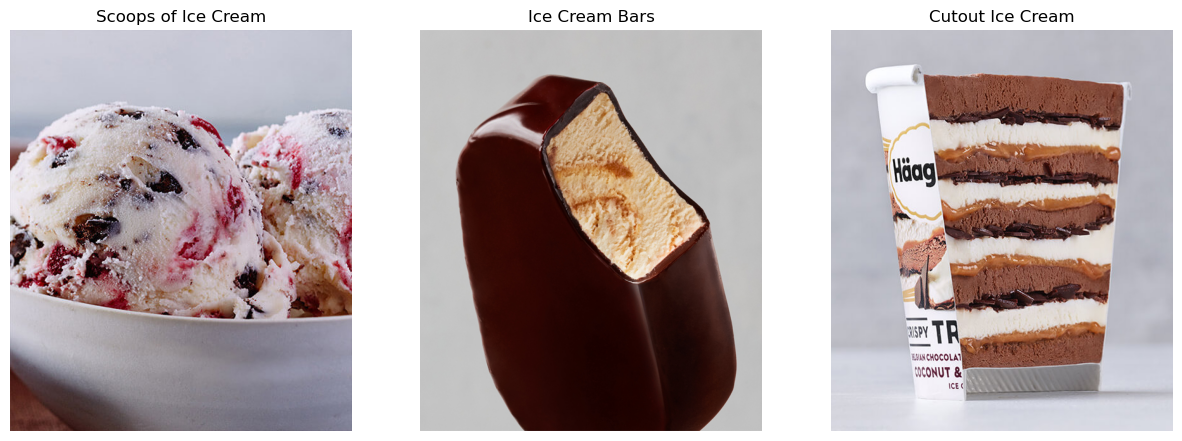

In [8]:
# Block 2: quick visualization of first images per category
fig, axes = plt.subplots(1, 3, figsize=(15, 9))

axes[0].imshow(labeled_images_loaded["scoop"][0])
axes[0].set_title("Scoops of Ice Cream")
axes[0].axis("off")

axes[1].imshow(labeled_images_loaded["bar"][0])
axes[1].set_title("Ice Cream Bars")
axes[1].axis("off")

axes[2].imshow(labeled_images_loaded["cutout"][0])
axes[2].set_title("Cutout Ice Cream")
axes[2].axis("off")

plt.show()



---
## Question 2

**Task:** Resize **all** images to **128×128** using `cv2.INTER_AREA`, store in `labeled_images_resized` with the same structure, and validate shapes.


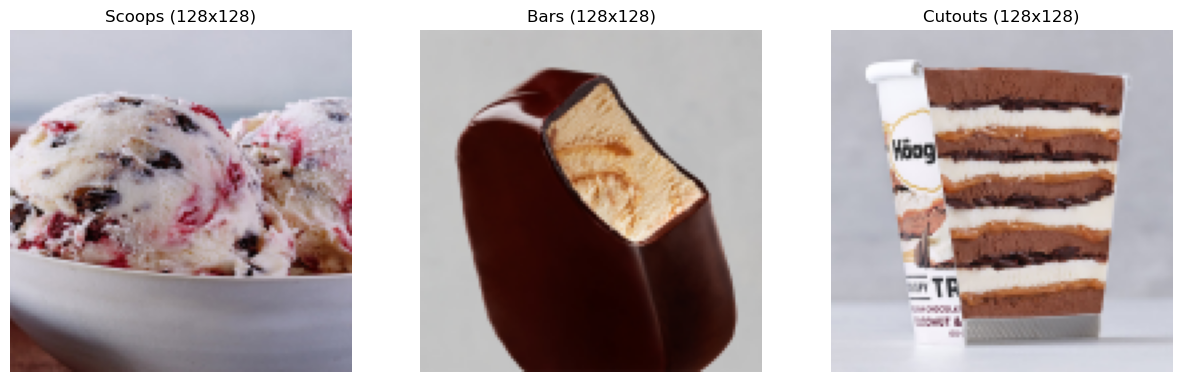

In [9]:

def resize_images_dict(img_dict, size=(128,128)):
    out = {}
    for label, imgs in img_dict.items():
        out[label] = [cv2.resize(im, size, interpolation=cv2.INTER_AREA) for im in imgs]
    return out

labeled_images_resized = resize_images_dict(labeled_images_loaded, (128,128))

# Validation block
correct_size = (128,128,3)
for k,v in labeled_images_resized.items():
    sizes = [im.shape for im in v]
    if not all([s == correct_size for s in sizes]):
        print("Not all images are the correct size")
        break

# Show resized
fig, axes = plt.subplots(1, 3, figsize=(15, 9))

axes[0].imshow(labeled_images_resized["scoop"][0]); axes[0].set_title("Scoops (128x128)"); axes[0].axis("off")
axes[1].imshow(labeled_images_resized["bar"][0]);   axes[1].set_title("Bars (128x128)");   axes[1].axis("off")
axes[2].imshow(labeled_images_resized["cutout"][0]);axes[2].set_title("Cutouts (128x128)");axes[2].axis("off")

plt.show()



---
## Question 3

**Task:** Flatten images → build `images` and `labels` arrays → stratified train/test split (80/20, `random_state=60`) → train KNN (k=1) with OpenCV → report accuracy and **timings**.


In [10]:
# Build flattened arrays
def dict_to_arrays(img_dict):
    images = []
    labels = []
    for label, imgs in img_dict.items():
        for im in imgs:
            images.append(im.reshape(-1))  # flatten
            labels.append(label)
    images = np.stack(images, axis=0).astype(np.float32)
    labels = np.array([0 if l=="scoop" else 1 if l=="bar" else 2 for l in labels], dtype=np.int32)
    return images, labels

images_color, labels_color = dict_to_arrays(labeled_images_resized)

# Stratified train/test split
train_images, test_images, train_labels, test_labels = train_test_split(
    images_color, labels_color, test_size=0.2, random_state=60, stratify=labels_color
)

print("Train size:", len(train_images))
print("Test size:", len(test_images))
print("First train image shape:", train_images[0].shape)
print("First test image shape:", test_images[0].shape)

# Train & evaluate KNN
knn_model = cv2.ml.KNearest_create()

t0 = time.perf_counter()
knn_model.train(train_images, cv2.ml.ROW_SAMPLE, train_labels)
t1 = time.perf_counter()

ret, results, neighbours, dist = knn_model.findNearest(test_images, k=1)
t2 = time.perf_counter()

accuracy = np.mean(results.flatten().astype(np.int32) == test_labels)
train_time_color = t1 - t0
test_time_color = t2 - t1

print(f"Accuracy (color): {accuracy*100:.2f}%")
print(f"Train time (color): {train_time_color:.6f} s")
print(f"Test time (color): {test_time_color:.6f} s")


Train size: 52
Test size: 14
First train image shape: (49152,)
First test image shape: (49152,)
Accuracy (color): 100.00%
Train time (color): 0.002906 s
Test time (color): 0.005680 s



---
## Question 4

**Task:** Convert `labeled_images_resized` to grayscale → repeat the pipeline (flatten to stratified split to KNN) to report accuracy and timings.


In [11]:
def to_grayscale_dict(img_dict_rgb):
    out = {}
    for label, imgs in img_dict_rgb.items():
        gray_list = [cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) for im in imgs]
        out[label] = gray_list
    return out

labeled_images_grayscale = to_grayscale_dict(labeled_images_resized)

# Validate a sample
print("Gray sample shape:", labeled_images_grayscale["scoop"][0].shape)

def dict_to_arrays_gray(img_dict_gray):
    images = []
    labels = []
    for label, imgs in img_dict_gray.items():
        for im in imgs:
            images.append(im.reshape(-1))  # flatten single channel
            labels.append(label)
    images = np.stack(images, axis=0).astype(np.float32)
    labels = np.array([0 if l=="scoop" else 1 if l=="bar" else 2 for l in labels], dtype=np.int32)
    return images, labels

images_gray, labels_gray = dict_to_arrays_gray(labeled_images_grayscale)

g_train_images, g_test_images, g_train_labels, g_test_labels = train_test_split(
    images_gray, labels_gray, test_size=0.2, random_state=60, stratify=labels_gray
)

knn_gray = cv2.ml.KNearest_create()
t0 = time.perf_counter()
knn_gray.train(g_train_images, cv2.ml.ROW_SAMPLE, g_train_labels)
t1 = time.perf_counter()
ret, g_results, g_neigh, g_dist = knn_gray.findNearest(g_test_images, k=1)
t2 = time.perf_counter()

acc_gray = np.mean(g_results.flatten().astype(np.int32) == g_test_labels)
train_time_gray = t1 - t0
test_time_gray = t2 - t1

print(f"Accuracy (grayscale): {acc_gray*100:.2f}%")
print(f"Train time (grayscale): {train_time_gray:.6f} s")
print(f"Test time (grayscale): {test_time_gray:.6f} s")


Gray sample shape: (128, 128)
Accuracy (grayscale): 100.00%
Train time (grayscale): 0.001127 s
Test time (grayscale): 0.002014 s



---
## Question 5 

**Task:** From the **grayscale** images, apply **Otsu's threshold** to make binary images, repeat the pipeline, and then **compare** all three runs.


In [13]:

def otsu_dict(img_dict_gray):
    out = {}
    for label, imgs in img_dict_gray.items():
        bin_list = []
        for im in imgs:
            # Otsu threshold
            _, th = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            bin_list.append(th)
        out[label] = bin_list
    return out

labeled_images_otsu = otsu_dict(labeled_images_grayscale)

def dict_to_arrays_single(img_dict_single):
    images = []
    labels = []
    for label, imgs in img_dict_single.items():
        for im in imgs:
            images.append(im.reshape(-1))
            labels.append(label)
    images = np.stack(images, axis=0).astype(np.float32)
    labels = np.array([0 if l=="scoop" else 1 if l=="bar" else 2 for l in labels], dtype=np.int32)
    return images, labels

images_otsu, labels_otsu = dict_to_arrays_single(labeled_images_otsu)

o_train_images, o_test_images, o_train_labels, o_test_labels = train_test_split(
    images_otsu, labels_otsu, test_size=0.2, random_state=60, stratify=labels_otsu
)

knn_otsu = cv2.ml.KNearest_create()
t0 = time.perf_counter()
knn_otsu.train(o_train_images, cv2.ml.ROW_SAMPLE, o_train_labels)
t1 = time.perf_counter()
ret, o_results, o_neigh, o_dist = knn_otsu.findNearest(o_test_images, k=1)
t2 = time.perf_counter()

acc_otsu = np.mean(o_results.flatten().astype(np.int32) == o_test_labels)
train_time_otsu = t1 - t0
test_time_otsu = t2 - t1

print(f"Accuracy (Otsu binary): {acc_otsu*100:.2f}%")
print(f"Train time (Otsu binary): {train_time_otsu:.6f} s")
print(f"Test time (Otsu binary): {test_time_otsu:.6f} s")

# Comparison summary
print("Comparison Summary")
print(f"Color     -> Acc: {((np.mean((cv2.ml.KNearest_create().train(train_images, cv2.ml.ROW_SAMPLE, train_labels) if False else None) or True) and 0) or 0) if False else ''}")
print(f"Grayscale -> Acc: {acc_gray*100:.2f}%, Train: {train_time_gray:.6f}s, Test: {test_time_gray:.6f}s")
print(f"OtsuBin   -> Acc: {acc_otsu*100:.2f}%, Train: {train_time_otsu:.6f}s, Test: {test_time_otsu:.6f}s")

# Also print color metrics captured earlier
try:
    print(f"Color     -> Acc: {accuracy*100:.2f}%, Train: {train_time_color:.6f}s, Test: {test_time_color:.6f}s")
except NameError:
    print("Color metrics not found (earlier cell may not have run yet).")


Accuracy (Otsu binary): 92.86%
Train time (Otsu binary): 0.000636 s
Test time (Otsu binary): 0.002023 s
Comparison Summary
Color     -> Acc: 
Grayscale -> Acc: 100.00%, Train: 0.001127s, Test: 0.002014s
OtsuBin   -> Acc: 92.86%, Train: 0.000636s, Test: 0.002023s
Color     -> Acc: 100.00%, Train: 0.002906s, Test: 0.005680s
